In [1]:
import os
import warnings
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import pvlib 
from pvlib.solarposition import get_solarposition
from shapely.geometry import Point
from sklearn.neighbors import KDTree

import os
import warnings
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import pvlib
from pvlib.solarposition import get_solarposition
from pvlib.irradiance import get_extra_radiation as E0_pvlib
from shapely.geometry import Point
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt # Repeated import kept for clarity within the plotting section

## Parameters

In [2]:
weather_path = "Observed_Meteorology_Paris_France_CdG_Airport_WBAN_071570_2000-24/Weather.csv"         # change if needed
radiation_path = "Observed_Meteorology_Paris_France_CdG_Airport_WBAN_071570_2000-24/Radiation.csv"     # optional; change if needed
base_path = "/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/EUR-11/*/*/historical/*/*/v*/3hr/{variable}/*/*200*"

#Constants
I_sc = 1367.0  # solar constant [W/m^2]
a, b = 17.27, 237.7  # Constants for the Magnus formula approximation used in dew point calculation.
eps = 1e-9

#Dat for observations
lat = 49.0097
lon = 2.5479   
start_date = "2000-01-01"
end_date  = "2024-12-30"

#Model
institution='KNMI'
RCM= 'NCC-NorESM1-M'
model= 'RACMO22E'
version = 'v1'
ensemble= 'r1i1p1'

In [3]:
# List of variables to analyze, mapped to DataFrame column names
variables = {
    'Shortwave Direct': 'Radiation_Shortwave_Direct_Wpm2(W/m^2)',
    'Shortwave Diffuse': 'Radiation_Shortwave_Diffuse_Wpm2(W/m^2)',
    'Longwave Downwelling': 'Radiation_Longwave_Downwelling_Wpm2(W/m^2)',
    'Longwave Upwelling': 'Radiation_Longwave_Upwelling_Wpm2(W/m^2)',
    'Net Radiation': 'Radiation_Net_Wpm2(W/m^2)',
    'Air Temperature': 'Temperature_Air_F(F)',
    'DewPoint Temperature': 'Temperature_DewPoint_F(F)',
    'Wind Speed': 'Wind_Speed_mps(m/s)',
    'Atmospheric Pressure': 'Pressure_Atmosphere_kPa(kPa)',
    'Precipitation Rate': 'Precipitation_Rate_mph(m/h)'
}


variables_obs = {
    # Calculated variables
    'Shortwave Downwelling': 'Radiation_Shortwave_Downwelling_Wpm2(W/m^2)', # rsds (GHI)
    'Shortwave Direct':      'Radiation_Shortwave_Direct_downwelling_Wpm2(W/m^2)',
    'Shortwave Diffuse':     'Radiation_Shortwave_Diffuse_downwelling_Wpm2(W/m^2)',
    'Shortwave Upwelling':   'Radiation_Shortwave_Upwelling_Wpm2(W/m^2)', # rsus
    'Longwave Downwelling':  'Radiation_Longwave_Downwelling_Wpm2(W/m^2)', # rlds
    'Longwave Upwelling':    'Radiation_Longwave_Upwelling_Wpm2(W/m^2)', # rlus
    'Net Radiation':         'Radiation_Net_Wpm2(W/m^2)',
    'Air Temperature':       'Temperature_Air_F(F)',
    'DewPoint Temperature':  'Temperature_DewPoint_F(F)',
    'Wind Speed':            'Wind_Speed_mps(m/s)',
    'Atmospheric Pressure':  'Pressure_Atmosphere_kPa(kPa)',
    'Precipitation Rate':    'Precipitation_Rate_mph(m/h)',
    'Relative Humidity':     'Humidity_Relative_pct(%)',
    'Total Cloud Fraction':  'Cloud_Fraction_Total_pct(%)',
}



# Units for Y-axes
units = {
    'Radiation_Shortwave_Direct_Wpm2(W/m^2)': 'W/m²',
    'Radiation_Shortwave_Diffuse_Wpm2(W/m^2)': 'W/m²',
    'Radiation_Longwave_Downwelling_Wpm2(W/m^2)': 'W/m²',
    'Radiation_Longwave_Upwelling_Wpm2(W/m^2)': 'W/m²',
    'Radiation_Net_Wpm2(W/m^2)': 'W/m²',
    'Temperature_Air_F(F)': 'F',
    'Temperature_DewPoint_F(F)': 'F',
    'Wind_Speed_mps(m/s)': 'm/s',
    'Pressure_Atmosphere_kPa(kPa)': 'kPa',
    'Precipitation_Rate_mph(m/h)': 'm/h'
}


mapping_mod2obs = {
    'rsds' : 'Shortwave Downwelling',    
    'rsus' : 'Shortwave Upwelling',      
    'rlds' : 'Longwave Downwelling',
    'rlus' : 'Longwave Upwelling',
    'rns'  : 'Net Radiation',           
    'tas'  : 'Air Temperature',          
    'tdps' : 'DewPoint Temperature',     
    'sfcWind' : 'Wind Speed',           
    'ps'   : 'Atmospheric Pressure',     
    'hurs' : 'Relative Humidity',        
    'pr'   : 'Precipitation Rate',       
    'clt'  : 'Total Cloud Fraction',     
}

## Functions

In [4]:
def read_weather(path):
    """Read weather CSV with flexible delimiter detection."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found.")
    # try comma then tab
    try:
        df = pd.read_csv(path, sep=",")
    except Exception:
        df = pd.read_csv(path, sep="\t")
    return df

def read_radiation(path):
    if not os.path.exists(path):
        return None
    try:
        df = pd.read_csv(path, sep=",")
    except Exception:
        df = pd.read_csv(path, sep="\t")
    return df

# Defining E0 locally based on your previous code, although pvlib's version is available
def E0(doy):
    """Calculates the eccentricity correction factor (E0) for the Earth-Sun distance."""
    return 1 + 0.033 * np.cos(2 * np.pi * doy / 365.0)

def kd_erbs(Kt):
    """Calculates the diffuse fraction (kd = DHI/GHI) using the Erbs model."""
    Kt = np.asarray(Kt)
    kd = np.zeros_like(Kt, dtype=float)
    
    # Low Clearness (Kt <= 0.22)
    m1 = Kt <= 0.22
    kd[m1] = 1.0 - 0.09 * Kt[m1]
    
    # Medium Clearness (0.22 < Kt <= 0.8)
    m2 = (Kt > 0.22) & (Kt <= 0.8)
    K = Kt[m2]
    kd[m2] = 0.9511 - 0.1604 * K + 4.388 * K**2 - 16.638 * K**3 + 12.336 * K**4
    
    # High Clearness (Kt > 0.8)
    kd[Kt > 0.8] = 0.165
    
    # Handle negative Kt (nighttime/zero G0h)
    kd = np.where(Kt < 0, 1.0, kd)
    return kd

def dew_point(T_C, RH):
    """
    Calculates the Dew Point Temperature (Td) in Celsius (°C) using the Magnus formula.
    T_C: Air Temperature in Celsius.
    RH: Relative Humidity in percent (%).
    """
    gamma = np.log(RH / 100.0) + (a * T_C) / (b + T_C)
    return (b * gamma) / (a - gamma)



# --- FUNCTIONS ---
def E0(doy):
    """
    Calculates the eccentricity correction factor (E0) for the Earth-Sun distance.
    This factor corrects the solar constant based on the Day of Year (doy).
    (Source: Duffie & Beckman)
    """
    return 1 + 0.033 * np.cos(2 * np.pi * doy / 365.0)

### Output directories

In [34]:
# --- Define Directory Names ---
data_dir = "data"
plots_dir = "plots"

# --- 1. Create Data Directory ---
try:
    os.makedirs(data_dir, exist_ok=True)
    print(f"Directory '{data_dir}' ensured.")
except Exception as e:
    print(f"Error creating directory '{data_dir}': {e}")

# --- 2. Create Plots Directory ---
try:
    os.makedirs(plots_dir, exist_ok=True)
    print(f"Directory '{plots_dir}' ensured.")
except Exception as e:
    print(f"Error creating directory '{plots_dir}': {e}")

Directory 'data' ensured.
Directory 'plots' ensured.


## Create dataframe for observations

### Weather data

In [5]:
# Load data
df_w = read_weather(weather_path)

# normalize columns names (strip spaces)
df_w.columns = [c.strip() for c in df_w.columns]

# attempt to detect datetime columns and create datetime
if "YYYYMMDD" in df_w.columns and "HH:MM:SS" in df_w.columns:
    # some files may have integer YYYYMMDD
    df_w["YYYYMMDD"] = df_w["YYYYMMDD"].astype(str)
    df_w["datetime"] = pd.to_datetime(df_w["YYYYMMDD"].str.zfill(8) + " " + df_w["HH:MM:SS"])
else:
    # try to find a generic datetime column
    df_w["datetime"] = pd.to_datetime(df_w[possible[0]])

### Radiation data

In [6]:
# load radiation if present
df_rad = read_radiation(radiation_path)
if df_rad is not None:
    df_rad.columns = [c.strip() for c in df_rad.columns]
    # try to create datetime in rad file in same way (so we can merge)
    if "YYYYMMDD" in df_rad.columns and "HH:MM:SS" in df_rad.columns:
        df_rad["YYYYMMDD"] = df_rad["YYYYMMDD"].astype(str)
        df_rad["datetime"] = pd.to_datetime(df_rad["YYYYMMDD"].str.zfill(8) + " " + df_rad["HH:MM:SS"])
    else:
        df_rad["datetime"] = pd.to_datetime(df_rad[poss[0]])

### Concat weather and radiation

In [7]:
if df_rad["datetime"].notnull().any():
    df = pd.merge(df_w, df_rad.drop(columns=[c for c in df_rad.columns if c=="datetime" and c not in df_w.columns]),
                  on="datetime", how="left", suffixes=("","_rad"))
else:
    df = pd.concat([df_w.reset_index(drop=True), df_rad.reset_index(drop=True)], axis=1)

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

## Fix bug
During the analysis of the Diurnal Cycle for the Precipitation_Rate_mph(m/h) variable, a critical data quality issue was identified. The hourly mean calculation revealed a non-physical, periodic pattern where the average precipitation rate was exactly zero (or extremely close to zero) during specific hours.

A subsequent verification confirmed that for the hours 1, 4, 7, 10, 13, 16, 19, and 22, the DataFrame contains zero positive precipitation events across the entire time series.

In [8]:
mask = (df['Precipitation_Rate_mph(m/h)'] == 0.0) & (df.index.hour.isin([1, 4, 7, 10, 13, 16, 19, 22]))
df.loc[mask, 'Precipitation_Rate_mph(m/h)'] = np.nan

## Plot annual and daily cicle for observations

## tas

In [9]:
df['tas']=df["Temperature_Air_F(F)"]

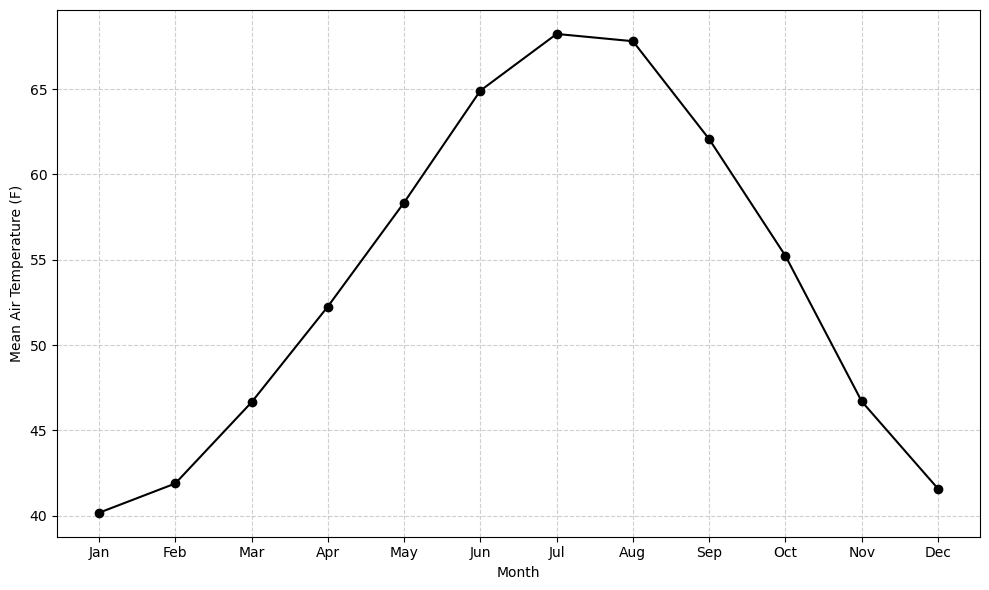

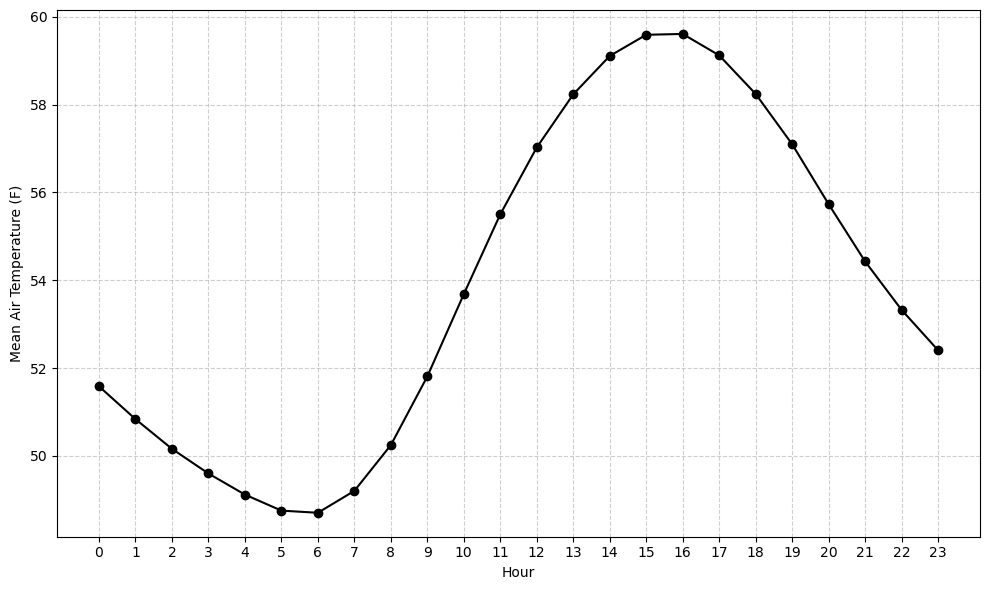

In [10]:
#Calculation of the Annual Cycle ---
annual_cycle = df['tas'].groupby(df.index.month).mean()

# Calculation of the Diurnal Cycle ---
diurnal_cycle = df['tas'].groupby(df.index.hour).mean()


# Annual Cycle Plot
plt.figure(figsize=(10, 6))
annual_cycle.plot(kind='line', marker='o', color='black')
plt.title('')
plt.xlabel('Month')
plt.ylabel('Mean Air Temperature (F)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('tas_annual_cycle_temperature.png')
# 

# Diurnal Cycle Plot
plt.figure(figsize=(10, 6))
diurnal_cycle.plot(kind='line', marker='o', color='black')
plt.title('')
plt.xlabel('Hour')
plt.ylabel('Mean Air Temperature (F)')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('tas_diurnal_cycle_temperature.png')
#

## All variables

Complete Annual Cycle Plot saved to: complete_annual_cycle_plot.png
Complete Diurnal Cycle Plot saved to: complete_diurnal_cycle_plot.png


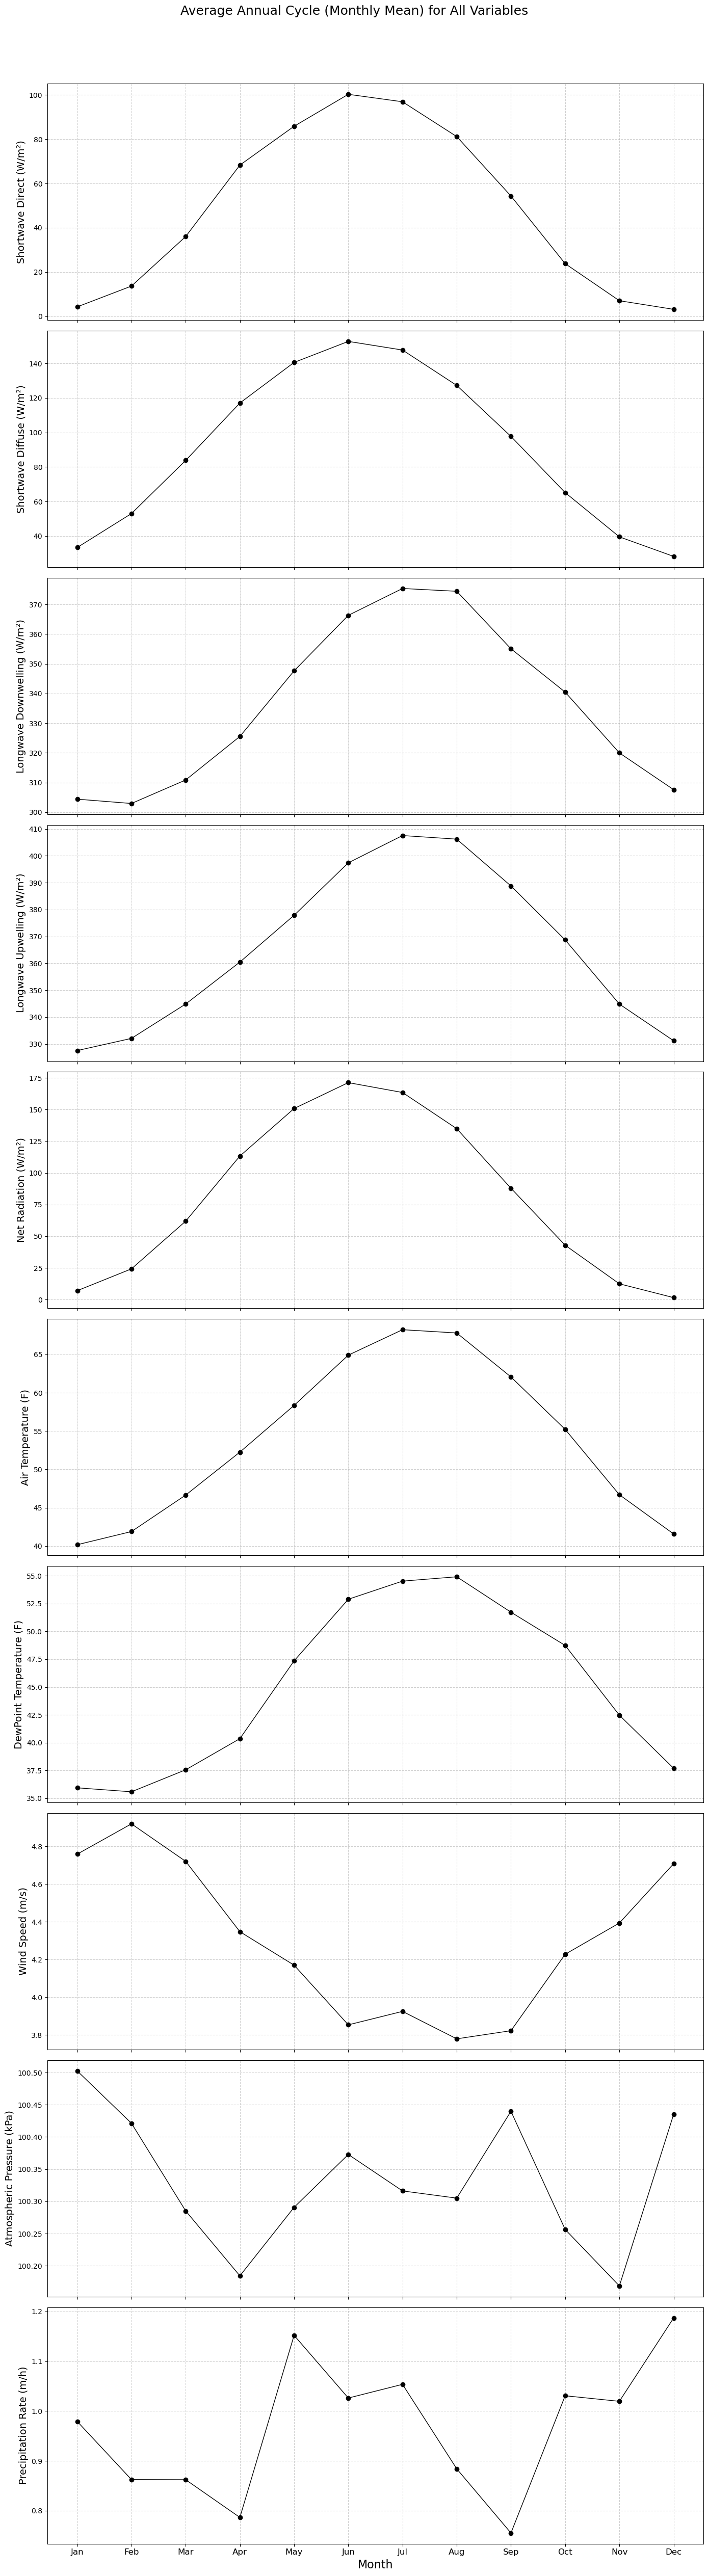

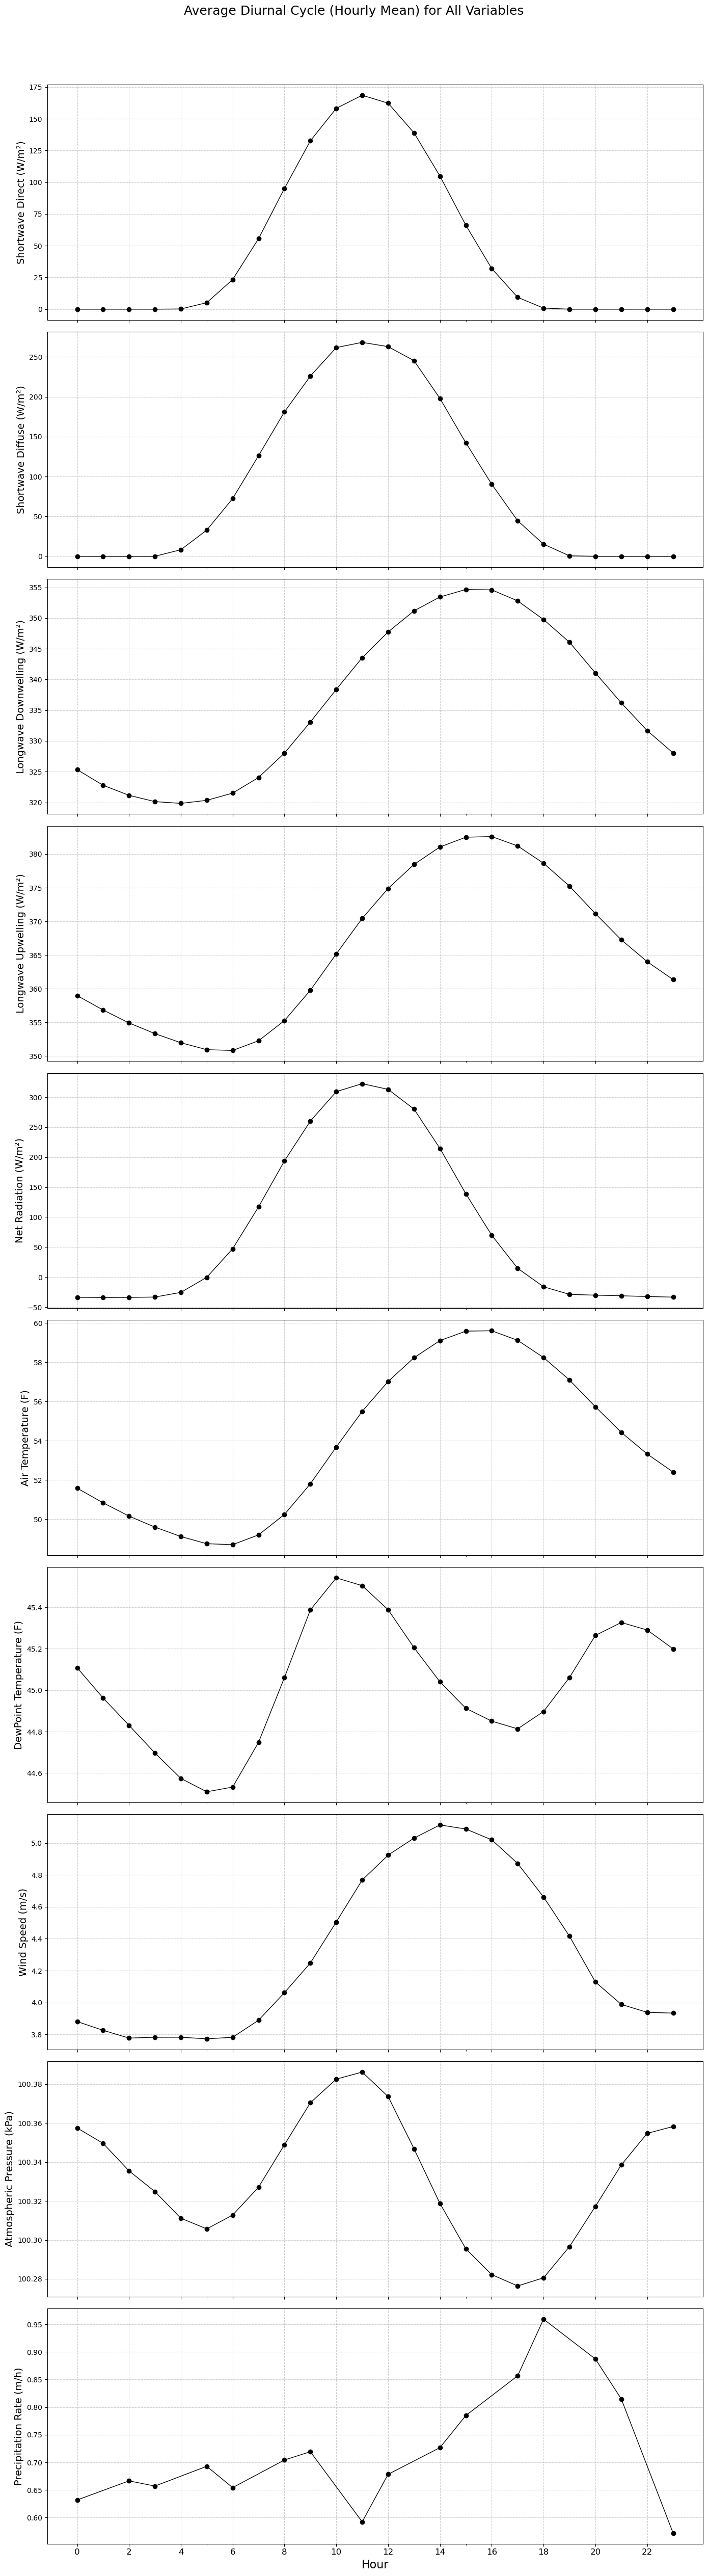

In [24]:
annual_cycles = {}
daily_cycles = {}

for name, col in variables.items():
    
    # Isolate the data Series and drop NaNs once
    data_series = df[col].dropna()
    
    if name == 'Precipitation Rate':
        annual_cycles[name] = data_series.groupby(data_series.index.month).sum()
        daily_precip_series = data_series.groupby(data_series.index.hour).sum()
        mask = daily_precip_series == 0.0
        daily_precip_series.loc[mask] = np.nan 
        daily_cycles[name] = daily_precip_series

    else:
        annual_cycles[name] = data_series.groupby(data_series.index.month).mean()
        daily_cycles[name] = data_series.groupby(data_series.index.hour).mean()

# Generating the Annual Cycle Plot (Subplots) ---
num_vars = len(variables)
# Increased size of figure and title
fig_annual, axes_annual = plt.subplots(num_vars, 1, figsize=(14, 5 * num_vars), sharex=True)
fig_annual.suptitle('Average Annual Cycle (Monthly Mean) for All Variables', fontsize=18, y=1.01) # Larger title

for i, (name, cycle) in enumerate(annual_cycles.items()):
    ax = axes_annual[i]
    col_name = variables[name]
    
    # Plotting: use marker 'o' and continuous line
    cycle.plot(ax=ax, kind='line', marker='o', color='black', linewidth=1)
    
    # Increased size of Y-label
    ax.set_ylabel(f'{name} ({units[col_name]})', fontsize=14) 
    ax.grid(True, linestyle='--', alpha=0.6)
    
# X-axis configuration for the last subplot
axes_annual[-1].set_xlabel('Month', fontsize=16) 
axes_annual[-1].set_xticks(ticks=range(1, 13))
axes_annual[-1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.99]) 
plt.savefig('complete_annual_cycle_plot.png')
print("Complete Annual Cycle Plot saved to: complete_annual_cycle_plot.png")

# Generating the Diurnal Cycle Plot (Subplots)
fig_daily, axes_daily = plt.subplots(num_vars, 1, figsize=(14, 5 * num_vars), sharex=True)
fig_daily.suptitle('Average Diurnal Cycle (Hourly Mean) for All Variables', fontsize=18, y=1.01) # Larger title

for i, (name, cycle) in enumerate(daily_cycles.items()):
    ax = axes_daily[i]
    col_name = variables[name]
    
    # PLOTTING AND INTERPOLATION LOGIC FOR PRECIPITATION 
    if name == 'Precipitation Rate':
        interpolated_cycle = cycle.interpolate(method='linear')
        interpolated_cycle.plot(ax=ax, kind='line', marker=' ', color='black', linewidth=1)
        cycle.plot(ax=ax, kind='line', marker='o', linestyle='', color='black', linewidth=1)
    else:
        cycle.plot(ax=ax, kind='line', marker='o', color='black', linewidth=1)
    
    ax.set_ylabel(f'{name} ({units[col_name]})', fontsize=14) 
    ax.grid(True, linestyle='--', alpha=0.6)
    
# X-axis configuration for the last subplot
axes_daily[-1].set_xlabel('Hour', fontsize=16) 
axes_daily[-1].set_xticks(range(0, 24, 2))
axes_daily[-1].tick_params(axis='x', labelsize=12) 

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.savefig('complete_diurnal_cycle_plot.png')

print("Complete Diurnal Cycle Plot saved to: complete_diurnal_cycle_plot.png")

## Comparison with model

### Load polygon

In [25]:
def load_ucdb_city(root, city):
    """
    Load and filter a city shapefile from the Urban Centre Database (UCDB).

    Parameters:
    root (str): The root directory where the shapefile is located.
    city (str): The name of the city to load.

    Returns:
    gpd.GeoDataFrame: A GeoDataFrame containing the filtered city shapefile.
    """
    ucdb_info = gpd.read_file(root + '/GHS_FUA_UCD/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')
    ucdb_city = ucdb_info.query(f'UC_NM_MN =="{city}"').to_crs(crs='EPSG:4326')
    if city == 'London':
        ucdb_city = ucdb_city[ucdb_city['CTR_MN_NM'] == 'United Kingdom']
    if city == 'Santiago':
        ucdb_city = ucdb_city[ucdb_city['CTR_MN_NM'] == 'Chile']
    if city == 'Barcelona':
        ucdb_city = ucdb_city[ucdb_city['CTR_MN_NM'] == 'Spain']
    if city == 'Dhaka':
        ucdb_city = ucdb_city[ucdb_city['CTR_MN_NM'] == 'Bangladesh']
    if city == 'Naples':
        ucdb_city = ucdb_city[ucdb_city['CTR_MN_NM'] == 'Italy']
    return ucdb_city
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'

ucdb_city = load_ucdb_city(root_nextcloud, "Paris")
ucdb_polygon = ucdb_city.unary_union

/tmp/ipykernel_34223/1996766404.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ucdb_polygon = ucdb_city.unary_union


### Select points near the selected lan y lon

In [26]:
rcm_institution_combo = f"{institution}-{model}" 
path_prefix = f"/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/EUR-11/{institution}/{RCM}/historical/{ensemble}/{model}/{version}/3hr/tas/"
file_pattern = f"*/*20*.nc"
glob_pattern = os.path.join(path_prefix, file_pattern)

all_files = glob.glob(glob_pattern)

if all_files:
    sample_file = all_files[0]
    ds= xr.open_dataset(sample_file)

In [27]:
lon_da = ds["lon"] 
lat_da = ds["lat"] 

# Flatten the 2D (lat/rlat, lon/rlon) coordinate arrays into 1D arrays.
lon_vals = lon_da.values.ravel() 
lat_vals = lat_da.values.ravel() 

# Construct a GeoDataFrame where each (lon_val, lat_val) is a Point geometry.
grid_points = gpd.GeoDataFrame(
    geometry=[Point(lon_vals[i], lat_vals[i]) for i in range(len(lon_vals))],
    crs="EPSG:4326" 
)

# Define a small bounding box (e.g., around Paris/CDG Airport) to limit the search area.
lat_min = 48.6
lat_max = 49.4
lon_min = 2.1
lon_max = 2.9

# Filter the GeoDataFrame to include only grid points within the bounding box.
grid_crop = grid_points[
    (grid_points.geometry.x >= lon_min) &
    (grid_points.geometry.x <= lon_max) &
    (grid_points.geometry.y >= lat_min) &
    (grid_points.geometry.y <= lat_max)
]

In [29]:
# ANTES de este bloque, las variables grid_crop, ucdb_polygon, outside_points y tree deben estar definidas.
# La variable 'outside_points' también requiere que 'inside' exista.

# --- 0. CORRECCIÓN: Asegurar la existencia de la columna 'inside' ---
# Esta línea faltaba o no se ejecutó en el entorno actual
try:
    # Calcula qué puntos de la grilla están dentro del polígono urbano (ucdb_polygon)
    grid_crop["inside"] = grid_crop.geometry.within(ucdb_polygon)
except NameError:
    # Esto ocurre si ucdb_polygon no está definido
    print("ERROR: ucdb_polygon no está definido. No se puede calcular la pertenencia.")
    raise

# --- 0. CORRECCIÓN: Asegurar la existencia de outside_points y tree ---
# Estos pasos son necesarios ya que la lógica de KDTree depende de 'outside_points'
outside_points = grid_crop[grid_crop["inside"] == False].copy()

# Las coordenadas de los puntos no urbanos para el KDTree
coords = np.column_stack([outside_points.geometry.x.values,
                          outside_points.geometry.y.values])
# Inicializar el KDTree
from sklearn.neighbors import KDTree
tree = KDTree(coords)


# --- 1. Identify the Urban Grid Points (Ahora funciona) ---
# Grid points that are INSIDE the urban boundary.
inside_points = grid_crop[grid_crop["inside"] == True] # <- AHORA 'inside' existe

if inside_points.empty:
    print("Warning: No grid points found inside the urban boundary (ucdb_polygon). Cannot select neighbors based on boundary proximity.")
    closest_points = pd.DataFrame() # Return empty DataFrame if no urban points are found
else:
    # --- 2. Extract Coordinates of Urban Points ---
    # These are the query points (the "boundary" area we are interested in).
    query_coords = np.column_stack([inside_points.geometry.x.values,
                                    inside_points.geometry.y.values])

    # --- 3. Query the KDTree (which indexes the OUTSIDE points) ---
    
    k_per_urban_point = 3 
    
    # Manejar el caso donde k_per_urban_point es mayor que el número de outside_points
    k_safe = min(k_per_urban_point, len(outside_points))
    
    # La variable 'tree' ya se definió en el paso de corrección 0.
    dist_all, idx_all = tree.query(query_coords, k=k_safe)

    # --- 4. Process and Select the Top 6 Unique Closest Neighbors ---

    distances = dist_all.ravel()
    indices_in_outside_points = idx_all.ravel()

    # Create a temporary DataFrame to hold the results
    temp_results = pd.DataFrame({
        'outside_index': indices_in_outside_points,
        'distance_deg': distances
    })
    
    # Aseguramos que outside_index sea el índice único para el groupby
    temp_results['outside_index'] = temp_results['outside_index'].astype(str)

    # Find the unique index for each outside point and keep the MINIMUM distance
    closest_unique_results = temp_results.loc[
        temp_results.groupby('outside_index')['distance_deg'].idxmin()
    ]

    # Sort by distance and select the top 6 points
    k = 6 # Final number of points to select
    
    # Convertimos el índice de vuelta a entero para iloc
    final_indices_int = closest_unique_results.sort_values(by='distance_deg').head(k)['outside_index'].astype(int).values

    # Retrieve the final GeoDataFrame rows
    # La variable 'outside_points' ya se definió en el paso de corrección 0.
    closest_points = outside_points.iloc[final_indices_int]
    
    # Assign the final shortest distance
    final_distances = closest_unique_results.sort_values(by='distance_deg').head(k)['distance_deg'].values
    
    # Usamos .loc para asegurar que la asignación funciona correctamente en GeoPandas
    closest_points.loc[closest_points.index, "distance_deg"] = final_distances

print(f"Selected {len(closest_points)} points closest to the UCDB boundary (and outside it).")

Selected 6 points closest to the UCDB boundary (and outside it).


/home/yaizaquintana/miniforge3/envs/UHI/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/yaizaquintana/miniforge3/envs/UHI/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Plot the points

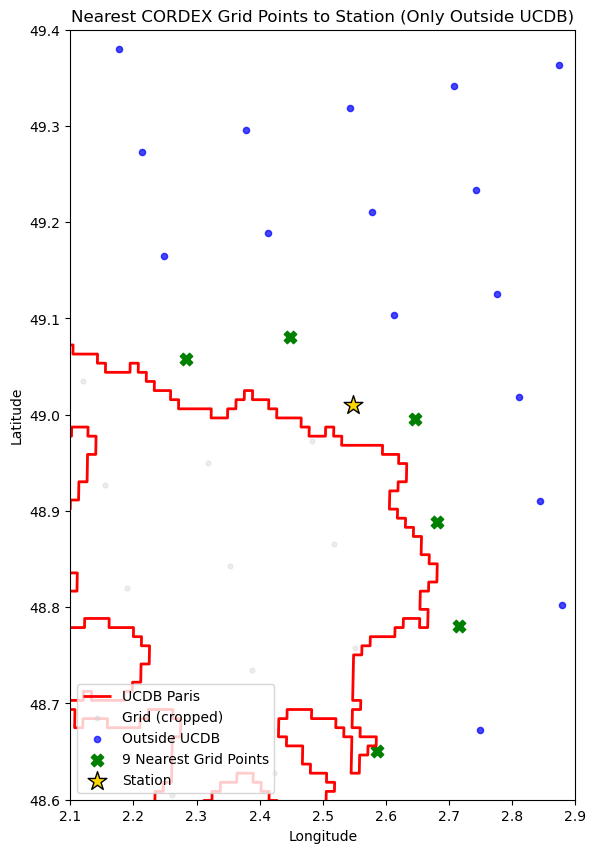

In [30]:
station_point = gpd.GeoDataFrame(
    geometry=[Point(lon, lat)],
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))

# Polígono UCDB
ucdb_city.boundary.plot(ax=ax, color="red", linewidth=2, label="UCDB Paris")

# Todos los puntos recortados
grid_crop.plot(ax=ax, markersize=12, color="lightgray", alpha=0.4, label="Grid (cropped)")

# Puntos fuera del polígono
outside_points.plot(ax=ax, markersize=20, color="blue", alpha=0.7, label="Outside UCDB")

# 9 puntos más cercanos
closest_points.plot(ax=ax, markersize=80, marker="X", color="green", label="9 Nearest Grid Points")

# Estación meteorológica
station_point.plot(ax=ax, markersize=200, marker="*", color="gold", edgecolor="black",
                   label="Station")

ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

ax.set_title("Nearest CORDEX Grid Points to Station (Only Outside UCDB)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.show()

In [31]:
# closest_points must contain geometry.x (lon) and geometry.y (lat)
selected_lons = closest_points.geometry.x.values
selected_lats = closest_points.geometry.y.values

print("Processing points:")
for i in range(len(selected_lats)):
    print(f"P{i}: lat={selected_lats[i]}, lon={selected_lons[i]}")


# ============================================================
# Final DataFrame (multi-point)
# ============================================================
df_final = pd.DataFrame()

# ============================================================
# Loop through CORDEX variables
# mapping_mod2obs and variables_obs already defined by you
# ============================================================
for var_mod, obs_name in mapping_mod2obs.items():
    print(f"\n Variable: {var_mod}, {obs_name} ")

    col_obs = variables_obs[obs_name]

    # --- 1. File Search ---
    path_prefix = f"/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/EUR-11/{institution}/{RCM}/*/{ensemble}/{model}/{version}/3hr/{var_mod}/"
    file_pattern = f"*/*20*.nc"
    search_pattern = os.path.join(path_prefix, file_pattern)
    files = sorted(glob.glob(search_pattern))

    # Check if files were found. If not, skip to the next variable.
    if not files:
        print(f"ATTENTION: No files found for variable {var_mod}. Skipping to the next variable...")
        continue

    # --- 2. Dataset Opening with Error Handling ---
    try:
        # Attempt to open the multi-dataset
        ds = xr.open_mfdataset(
            files,
            combine='by_coords',
            chunks={'time': 100},
            decode_coords='all',
        )
    except Exception as e:
        # Catch any error during opening (e.g., corrupted files, memory issues)
        print(f"ERROR: Failed to open files for variable {var_mod}. Error: {e}")
        continue  # Skip to the next variable in the loop

    # --- 3. Dataset Processing ---
    time_slice = slice(start_date, end_date)
    
    # Use a try-except block here in case ds.sel fails (e.g., time coordinate is missing)
    try:
        ds = ds.sel(time=time_slice)
    except KeyError as e:
        print(f"ERROR: Time selection failed for {var_mod}. Is the 'time' coordinate present? Error: {e}")
        continue

    # Detect coordinate names
    if "rlon" in ds.coords and "rlat" in ds.coords:
        x_sel, y_sel = "rlon", "rlat"
    elif "x" in ds.coords and "y" in ds.coords:
        x_sel, y_sel = "x", "y"
    else:
        # Skip if necessary coordinates are missing
        print(f" ERROR: Dataset for {var_mod} lacks 'rlon/rlat' or 'x/y' coordinates. Skipping.")
        continue

    # Precompute squared distance grid
    lat_grid = ds["lat"]
    lon_grid = ds["lon"]

    # Loop over the selected points
    for i in range(len(selected_lats)):

        lat0 = selected_lats[i]
        lon0 = selected_lons[i]

        print(f"Processing point P{i}: lat={lat0}, lon={lon0}")

        # Squared distance on lat/lon grid
        squared_diff = (lat_grid - lat0)**2 + (lon_grid - lon0)**2

        # Index of nearest grid point
        min_idx = squared_diff.argmin(dim=[y_sel, x_sel])

        # Extract series
        da_point = ds[var_mod].isel(
            **{y_sel: int(min_idx[y_sel]), x_sel: int(min_idx[x_sel])}
        )

        da_point = da_point.reset_coords(drop=True)
        df_point = da_point.to_dataframe(name=f"{col_obs}_P{i}")

        # Add date fields
        df_point["YYYYMMDD"] = [
            f"{t.year:04d}{t.month:02d}{t.day:02d}" for t in df_point.index
        ]
        df_point["HH:MM:SS"] = [
            f"{t.hour:02d}:{t.minute:02d}:{t.second:02d}" for t in df_point.index
        ]

        # MultiIndex for merging
        df_point = df_point.set_index(["YYYYMMDD", "HH:MM:SS"])

        # Merge into final DataFrame
        if df_final.empty:
            df_final = df_point
        else:
            df_final = df_final.join(df_point, how="outer")

# Restore time column
df_final = df_final.reset_index()

df_final["Time_Index_Aux"] = pd.to_datetime(
    df_final["YYYYMMDD"] + " " + df_final["HH:MM:SS"],
    errors="coerce"
)

Processing points:
P0: lat=48.650232563761726, lon=2.586096642263499
P1: lat=49.08072615500721, lon=2.447809117412021
P2: lat=49.05776960101824, lon=2.2836143415778167
P3: lat=48.780444461298494, lon=2.715068363712504
P4: lat=48.88812227438098, lon=2.680911948942338
P5: lat=48.99578995651573, lon=2.6466081174287694

 Variable: rsds, Shortwave Downwelling 
Processing point P0: lat=48.650232563761726, lon=2.586096642263499
Processing point P1: lat=49.08072615500721, lon=2.447809117412021


KeyboardInterrupt: 

### Calculate derived variables and change unit to adapt to observations

In [147]:
# Detect all point suffixes
import re

pattern = r"_P(\d+)$"
point_ids = sorted({
    int(re.search(pattern, c).group(1))
    for c in df_final.columns
    if re.search(pattern, c)
})
print("Detected points:", point_ids)


Detected points: [0, 1, 2, 3, 4, 5, 6]


In [149]:
# --- Ensure Time_Index_Aux is created and valid ---
# This column is crucial for pvlib calculations.
if "Time_Index_Aux" not in df_final.columns:
    print("INFO: Creating 'Time_Index_Aux' column...")
    df_final["Time_Index_Aux"] = pd.to_datetime(
        df_final["YYYYMMDD"].astype(str) + " " + df_final["HH:MM:SS"].astype(str),
        format="%Y%m%d %H:%M:%S", 
        errors='coerce' # Vital for handling non-standard CORDEX dates (e.g., Feb 30th)
    )
    # Drop rows where time conversion failed (NaT)
    df_final = df_final.dropna(subset=["Time_Index_Aux"])
    print(f"INFO: {len(df_final)} valid time steps remaining.")

# --- Initialize Target DataFrame ---
# Create the observation-like DataFrame, starting with the time index.
df_obs_like = pd.DataFrame()
df_obs_like["Time_Index_Aux"] = df_final["Time_Index_Aux"]

# Define the point IDs (P0 to P8) to loop through.
point_ids = list(range(9)) 

# Assume 'lat' and 'lon' are globally defined target coordinates (e.g., 49.0, 2.5).

In [35]:
# Define the point IDs (P0 to P8)
point_ids = list(range(9)) 

# --- FIX: Ensure Index is Unique and Time Index has no Duplicates ---
# Resetting the index ensures the internal pandas index is unique (0, 1, 2, ...)
if not df_final.index.is_unique:
    df_final = df_final.reset_index(drop=True)

# Drop duplicates based on the critical time column before proceeding
df_final = df_final.drop_duplicates(subset=["YYYYMMDD", "HH:MM:SS"]).reset_index(drop=True)
print(f"INFO: DataFrame index is now unique. Total rows after dropping time duplicates: {len(df_final)}")# Ensure 'Time_Index_Aux' exists and is valid (required for pvlib and grouping)
if "Time_Index_Aux" not in df_final.columns:
    print("INFO: Creating 'Time_Index_Aux' column...")
    df_final["Time_Index_Aux"] = pd.to_datetime(
        df_final["YYYYMMDD"].astype(str) + " " + df_final["HH:MM:SS"].astype(str),
        format="%Y%m%d %H:%M:%S", errors='coerce'
    )
    df_final = df_final.dropna(subset=["Time_Index_Aux"])
    print(f"INFO: {len(df_final)} valid time steps remaining.")

# --- Initialize Target DataFrame ---
df_obs_like = pd.DataFrame()
df_obs_like["Time_Index_Aux"] = df_final["Time_Index_Aux"]


print("\n--- Starting CORDEX to OBS-like Conversion (P0-P8) ---")
for pid in point_ids:
    suffix = f"_P{pid}"
    
    # --- 1. Basic Variable Conversions & Copy (FIXED & DEBUGGED) ---
    
    # Lista Maestra: (Nombre Columna Base, Función Lambda, Unidad CORDEX, Unidad OBS)
    conversion_map = [
        # Air Temperature: K -> °F (tas)
        ("Temperature_Air_F(F)", lambda x: (x - 273.15) * 1.8 + 32, "K", "°F"),
        # Atmospheric Pressure: Pa -> kPa (ps)
        ("Pressure_Atmosphere_kPa(kPa)", lambda x: x / 1000.0, "Pa", "kPa"),
        # Precipitation Rate: kg m-2 s-1 -> m/h (pr)
        # 1 kg m-2 s-1 = 3600 mm/h. 1 mm/h = 1/1000 m/h.
        ("Precipitation_Rate_mph(m/h)", lambda x: x * 3.6, "kg m-2 s-1", "m/h"), 
        
        # --- Variables que SE COPIAN DIRECTAMENTE ---
        ("Wind_Speed_mps(m/s)", lambda x: x, "m/s", "m/s"),
        ("Radiation_Shortwave_Downwelling_Wpm2(W/m^2)", lambda x: x, "W/m²", "W/m²"), 
        ("Radiation_Shortwave_Upwelling_Wpm2(W/m^2)", lambda x: x, "W/m²", "W/m²"),  
        ("Radiation_Longwave_Downwelling_Wpm2(W/m^2)", lambda x: x, "W/m²", "W/m²"), 
        ("Radiation_Longwave_Upwelling_Wpm2(W/m^2)", lambda x: x, "W/m²", "W/m²"),   
        ("Humidity_Relative_pct(%)", lambda x: x, "%", "%"),                     
        ("Cloud_Fraction_Total_pct(%)", lambda x: x, "%", "%")                  
    ]

    for var_long_name, conversion_func, unit_cordex, unit_obs in conversion_map:
        col_in = f"{var_long_name}{suffix}"
        if col_in in df_final.columns:
            raw_data = df_final[col_in]
            converted_data = conversion_func(raw_data)
            
            # --- DEBUG PRINT ---
            if pid == 0 and unit_cordex != unit_obs:
                print(f"--- DEBUG P0: {var_long_name} ---")
                print(f"  RAW (CORDEX {unit_cordex}): Min={raw_data.min():.2f}, Mean={raw_data.mean():.2f}, Max={raw_data.max():.2f}")
                print(f"  OBS (Convert {unit_obs}): Min={converted_data.min():.2f}, Mean={converted_data.mean():.2f}, Max={converted_data.max():.2f}")
                print("-" * 30)
            
            # Aplica conversión (o copia) y GUARDA en df_obs_like
            df_obs_like[col_in] = converted_data
        else:
            print(f"Missing column for conversion/copy: {col_in}")
    # END OF CONVERSION LOOP
    
    # --- 2. Dew Point Calculation (Tdps) ---
    tas_F_col = f"Temperature_Air_F(F){suffix}"
    RH_col    = f"Humidity_Relative_pct(%)_P{pid}"
    Td_col    = f"Temperature_DewPoint_F(F){suffix}"
    
    # Use the newly converted T_Air (°F) from df_obs_like
    if tas_F_col in df_obs_like.columns and RH_col in df_obs_like.columns: # RH is now also in df_obs_like
        # Convert T_Air from °F back to °C (required by dew_point function)
        tas_C = (df_obs_like[tas_F_col] - 32) / 1.8 
        # Calculate Dew Point in °C
        Td_C = dew_point(tas_C, df_obs_like[RH_col]) # Use RH from df_obs_like
        # Convert Dew Point from °C to °F for output
        df_obs_like[Td_col] = Td_C * 1.8 + 32
        
        # --- DEBUG PRINT Td ---
        if pid == 0:
             print(f"--- DEBUG P0: Dew Point (Calculated) ---")
             print(f"  Td (°F): Mean={df_obs_like[Td_col].mean():.2f}")
             print("-" * 30)
    else:
        print(f"Cannot compute Dew Point for P{pid}: Missing T_Air (°F) or RH (%) column.")

    # --- 3. Net Radiation Calculation (Rnet) ---
    # AHORA se leen las columnas de df_obs_like (porque ya fueron copiadas en el paso 1)
    rsds_col = f"Radiation_Shortwave_Downwelling_Wpm2(W/m^2){suffix}" # GHI
    rsus_col = f"Radiation_Shortwave_Upwelling_Wpm2(W/m^2){suffix}"
    rlds_col = f"Radiation_Longwave_Downwelling_Wpm2(W/m^2){suffix}"
    rlus_col = f"Radiation_Longwave_Upwelling_Wpm2(W/m^2){suffix}"
    net_col  = f"Radiation_Net_Wpm2(W/m^2){suffix}"
    
    if all(c in df_obs_like.columns for c in [rsds_col, rsus_col, rlds_col, rlus_col]):
        # R_net = (Rs_down - Rs_up) + (Rl_down - Rl_up)
        df_obs_like[net_col] = (df_obs_like[rsds_col] - df_obs_like[rsus_col]) + \
                               (df_obs_like[rlds_col] - df_obs_like[rlus_col])
        # --- DEBUG PRINT Net Rad ---
        if pid == 0:
             print(f"--- DEBUG P0: Net Radiation (Calculated) ---")
             print(f"  Rnet (W/m²): Mean={df_obs_like[net_col].mean():.2f}")
             print("-" * 30)
    else:
        print(f"Cannot compute Net Radiation for P{pid}: Missing radiation components in df_obs_like.")
        df_obs_like[net_col] = np.nan

    # --- 4. Shortwave Direct/Diffuse Calculation (Erbs Model) ---
    direct_col  = f"Radiation_Shortwave_Direct_downwelling_Wpm2(W/m^2){suffix}"
    diffuse_col = f"Radiation_Shortwave_Diffuse_downwelling_Wpm2(W/m^2){suffix}"
    df_obs_like[direct_col] = np.nan
    df_obs_like[diffuse_col] = np.nan

    if rsds_col in df_obs_like.columns:
        clt_col  = f"Cloud_Fraction_Total_pct(%)_P{pid}"
        
        # Setup temporary DF for pvlib calculation
        df_p = pd.DataFrame()
        df_p["rsds"] = df_obs_like[rsds_col] # Use rsds from df_obs_like
        
        # Cloud Fraction Normalization (0 to 1.0)
        clt_norm = df_obs_like[clt_col] / 100.0 if clt_col in df_obs_like.columns else 0.0 # Use clt from df_obs_like
        df_p["clt"] = clt_norm
        
        # Time setup (midpoint of the 3-hour interval)
        # Note: Timezone localization should be handled here if not done previously
        df_p["time_mid"] = df_obs_like["Time_Index_Aux"] + pd.Timedelta(hours=1.5)
        # Assuming df_p["time_mid"] must be timezone-aware for pvlib
        time_tz_aware = df_p["time_mid"].dt.tz_localize('UTC', nonexistent='shift_forward', ambiguous='NaT')
        
        # Solar Position and G0h (Extraterrestrial Radiation)
        solpos = get_solarposition(time_tz_aware, latitude=lat, longitude=lon)
        # Original (Causes the error due to index mismatch/duplicates):
        # df_p["cos_theta"] = np.cos(np.deg2rad(solpos["zenith"])) 
        
        # CORREGIDO (Usa .values para asignar el array numpy directamente):
        df_p["cos_theta"] = np.cos(np.deg2rad(solpos["zenith"].values))
        df_p["doy"] = df_p["time_mid"].dt.dayofyear
        df_p["E0"]  = E0(df_p["doy"])
        df_p["G0h"] = I_sc * df_p["E0"] * df_p["cos_theta"]
        
        # Clearness Index (Kt)
        eps = 1e-6
        df_p["Kt"] = np.where(df_p["G0h"] > eps, df_p["rsds"] / df_p["G0h"], -1.0)
        
        # Diffuse Fraction (kd)
        df_p["kd_erbs"] = kd_erbs(df_p["Kt"])
        df_p["kd_final"] = (1 - df_p["clt"]) * df_p["kd_erbs"] + df_p["clt"] * 1.0
        
        # Separation into DHI and Direct components
        DHI = df_p["kd_final"] * df_p["rsds"]
        DNI = np.where(df_p["cos_theta"] > 0, (df_p["rsds"] - DHI) / df_p["cos_theta"], 0.0)
        Direct = np.clip(DNI * df_p["cos_theta"], 0, None)
        
        # Assign results
        df_obs_like.loc[df_obs_like.index, direct_col]  = Direct
        df_obs_like.loc[df_obs_like.index, diffuse_col] = DHI

        # --- DEBUG PRINT Direct/Diffuse ---
        if pid == 0:
             print(f"--- DEBUG P0: Direct/Diffuse (Calculated) ---")
             print(f"  Direct (W/m²): Mean={Direct.mean():.2f}")
        
             print(f"  Diffuse (W/m²): Mean={DHI.mean():.2f}")
             print("-" * 30)

    else:
        print(f"Cannot compute Direct/Diffuse for P{pid}: Missing rsds (GHI) column in df_obs_like.")

print("CORDEX formatted as OBS-like with conversions.")

filename = f"df_OBS_LIKE_{institution}_{RCM}_{model}_{version}_{ensemble}.csv"
full_path = os.path.join(data_dir, filename)

try:
    df_obs_like.to_csv(full_path, index=True, index_label="Time_Index_Aux") 
except Exception as e:
    print(f"\n Error error saving DataFrame: {e}")

KeyError: Index(['HH:MM:SS', 'YYYYMMDD'], dtype='object')

## Annual cycle and diurnal cycle

In [153]:
# Initialize dictionaries for aggregated cycles (must use df_obs_like data)
annual_cycles_mod = {name:{} for name in variables_obs.keys()}
daily_cycles_mod  = {name:{} for name in variables_obs.keys()}

print("--- Computing Annual and Daily Cycles ---")
for name, col_obs in variables_obs.items():
    for pid in point_ids:
        col_mod = f"{col_obs}_P{pid}"
        if col_mod not in df_obs_like.columns:
            continue
        if name == 'Precipitation Rate':
            # Annual cycle (Monthly Mean)
            annual_cycles_mod[name][pid] = df_obs_like.groupby(df_obs_like["Time_Index_Aux"].dt.month)[col_mod].sum()
            
            # Daily cycle (Hourly Mean)
            daily_cycles_mod[name][pid] = df_obs_like.groupby(df_obs_like["Time_Index_Aux"].dt.hour)[col_mod].sum()
        else:
            # Annual cycle (Monthly Mean)
            annual_cycles_mod[name][pid] = df_obs_like.groupby(df_obs_like["Time_Index_Aux"].dt.month)[col_mod].mean()
            
            # Daily cycle (Hourly Mean)
            daily_cycles_mod[name][pid] = df_obs_like.groupby(df_obs_like["Time_Index_Aux"].dt.hour)[col_mod].mean()


--- Computing Annual and Daily Cycles ---


Saved: annual_cycle_all_points.png


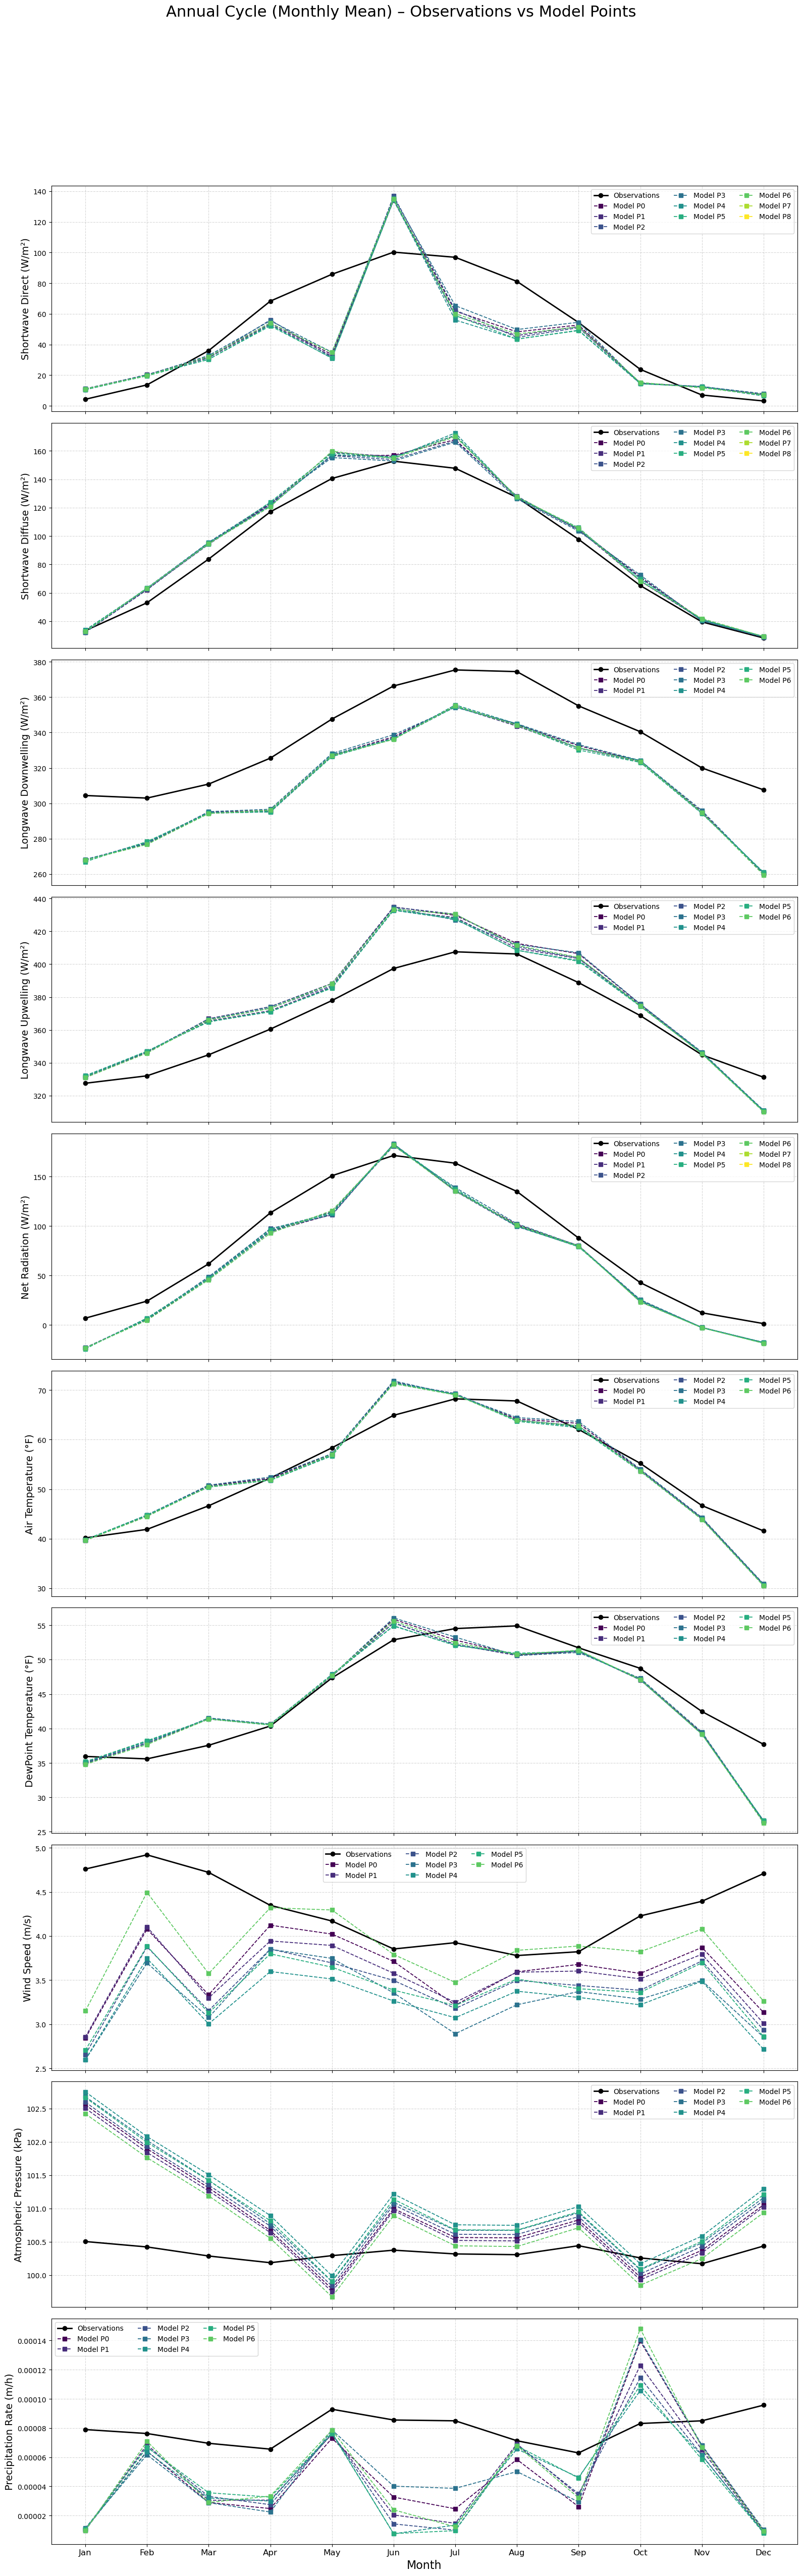

In [154]:
# --- PLOTTING BLOCK (Annual Cycle) ---
num_vars = len(annual_cycles)
fig_ann, axes = plt.subplots(num_vars, 1, figsize=(16, 5 * num_vars), sharex=True)

fig_ann.suptitle("Annual Cycle (Monthly Mean) – Observations vs Model Points",
                 fontsize=22, y=1.02)

if num_vars == 1:
    axes = [axes]

colors = plt.cm.viridis(np.linspace(0, 1, len(point_ids)))

for i, (name, obs_cycle) in enumerate(annual_cycles.items()):
    ax = axes[i]

    # OBS Data Plot
    ax.plot(obs_cycle.index, obs_cycle.values,
              marker='o', color='black', linewidth=2, label="Observations")

    # MODEL Data Plot (P0 to P8)
    for j, pid in enumerate(point_ids):
        mod_cycle = annual_cycles_mod[name].get(pid, None)
        if mod_cycle is None:
            continue

        ax.plot(mod_cycle.index, mod_cycle.values,
                  marker='s', linestyle='--', linewidth=1.3,
                  color=colors[j],
                  label=f"Model P{pid}")

    ax.set_ylabel(f"{name} ({units.get(name, 'Unit')})", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=10, ncol=3)

# X-axis formatting
axes[-1].set_xticks(range(1, 13))
axes[-1].set_xticklabels(
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
    fontsize=12
)
axes[-1].set_xlabel("Month", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{plots_dir}/annual_cycle_all_points_{institution}_{RCM}_{model}_{version}_{ensemble}.png", dpi=300)

In [ ]:
num_vars = len(daily_cycles)
# Create figure and subplots
fig_day, axes_day = plt.subplots(num_vars, 1, figsize=(16, 5 * num_vars), sharex=True)

# Update the plot title to reflect hourly aggregation
fig_day.suptitle("Diurnal Cycle (Hourly Aggregation) – Observations vs Model Points",
                 fontsize=22, y=1.02)

# Ensure 'axes_day' is iterable even if only one variable is present
if num_vars == 1:
    axes_day = [axes_day]

# Define colors for the model points using a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(point_ids)))

for i, (name, obs_cycle) in enumerate(daily_cycles.items()):
    ax = axes_day[i]

    # --- 1. OBS Data Plot ---
    # Plot observations as a line with markers
    ax.plot(obs_cycle.index, obs_cycle.values,
            marker='o', color='black', linewidth=2, label="Observations")

    # --- 2. MODEL Data Plot (Looping through all grid points) ---
    for j, pid in enumerate(point_ids):
        # Retrieve the model cycle for the current variable and point ID (pid)
        # Assumes daily_cycles_mod[variable_name] returns a dict {pid: Series}
        mod_cycle = daily_cycles_mod[name].get(pid, None)

        if mod_cycle is None:
            # Skip if no model data is available for this point/variable combination
            continue

        # --- Interpolation for Smooth Line ---
        full_hourly_index = pd.Index(range(24), name=mod_cycle.index.name)

        # Reindex the 3-hourly data to the full hourly index and interpolate linearly
        interpolated_cycle = mod_cycle.reindex(full_hourly_index).interpolate(method='linear')

        # 2. Plot the interpolated (smooth) line without markers
        ax.plot(interpolated_cycle.index, interpolated_cycle.values,
                marker='', linestyle='-', linewidth=1.3,
                color=colors[j],
                label=f"Model P{pid} (Interpolated)")

        # 3. Plot the actual 3-hourly points (markers only)
        ax.plot(mod_cycle.index, mod_cycle.values,
                marker='s', linestyle='', linewidth=0,
                color=colors[j],
                alpha=0.7) # Slightly transparent markers

    # Y-axis: Set the variable name and units
    ax.set_ylabel(f"{name} ({units.get(name, 'Unit')})", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=10, ncol=3)

# --- X-axis formatting (Hours) ---
# Apply formatting to the last subplot only
axes_day[-1].set_xticks(range(0, 24, 2)) # Set ticks every 2 hours (0, 2, 4, ..., 22)
axes_day[-1].set_xticklabels(
    [str(h) for h in range(0, 24, 2)], # Labels as hour numbers
    fontsize=12
)
axes_day[-1].set_xlabel("Hour (UTC)", fontsize=16)
ax.set_xlim(-0.5, 23.5) # Ensure x-axis covers the full 0-23 range

plt.tight_layout(rect=[0, 0, 1, 0.96])
# Save the plot with dynamic naming based on simulation parameters
plt.savefig(f"diurnal_cycle_interpolated_{institution}_{RCM}_{model}_{version}_{ensemble}.png", dpi=300)
print(f"Diurnal Cycle Plot saved to: diurnal_cycle_interpolated_{institution}_{RCM}_{model}_{version}_{ensemble}.png")